### Figure sugestions 

1. For which purposes is gas used in EU today (percentage of electricity generation, heating, industry ...) + For which purposes we expect to use gas in 2030 (transition path without/with gas limitations)

2. When do we expect new technologies substituting gas ( i.e, methanation by Sabatier reaction and biogas upgrade into biomethane) to appear in the model for the ambitious (1.5C budget) and less ambitious (2C budget)?. Do these transformations appear earlier when limiting the use of gas?

3. How does the heating supply evolve with/without gas? What are the required ramping rates for the heat pumps?

4. What is the total cost evolution for the system with/without a gas limit? How more expensive is the transition because of the gas limit? Is the cumulative cost 1% or 10% more expensive?

5. Typically, gas covers the winter peaks (for electricity generation and heating demand), which technology is taking care of the peaks under a limited-gas scenario?

- Gas consumption vs time step. A dashed line indicates the cap. Two lines are drawn. One for a baseline with no cap and another with the cap. On the same figure (maybe in another panel) we show the shadow price for gas. If the cap is binding, the price should be higher than our regular gas price.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pypsa
import warnings
import yaml
warnings.filterwarnings("ignore")
import pickle
import os

from matplotlib import rc
rc('text', usetex=False)

In [2]:
with open('./tech_colors.yaml') as file:
    tech_colors = yaml.safe_load(file)['tech_colors']
tech_colors['ambient heat'] = tech_colors['heat pumps']

In [3]:
override_component_attrs = pypsa.descriptors.Dict({k : v.copy() for k,v in pypsa.components.component_attrs.items()})
override_component_attrs["Link"].loc["bus2"] = ["string",np.nan,np.nan,"2nd bus","Input (optional)"]
override_component_attrs["Link"].loc["bus3"] = ["string",np.nan,np.nan,"3rd bus","Input (optional)"]
override_component_attrs["Link"].loc["bus4"] = ["string",np.nan,np.nan,"4th bus","Input (optional)"]
override_component_attrs["Link"].loc["efficiency2"] = ["static or series","per unit",1.,"2nd bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["efficiency3"] = ["static or series","per unit",1.,"3rd bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["efficiency4"] = ["static or series","per unit",1.,"4th bus efficiency","Input (optional)"]
override_component_attrs["Link"].loc["p2"] = ["series","MW",0.,"2nd bus output","Output"]
override_component_attrs["Link"].loc["p3"] = ["series","MW",0.,"3rd bus output","Output"]
override_component_attrs["Link"].loc["p4"] = ["series","MW",0.,"4th bus output","Output"]

In [4]:
fs = 18
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs

In [13]:
def import_df(path,scenario,n_index=3,n_header=4):
    df = pd.read_csv(path,index_col=list(range(n_index)),header=list(range(n_header)))
    df = df.droplevel(0,axis=1)
    df = df.droplevel(0,axis=1)
    df = df.loc[:,['3H-T-H-B-I-A-solar+p3-dist1-cb25.7ex0','3H-T-H-B-I-A-solar+p3-dist1-cb73.9ex0','3H-T-H-B-I-A-solar+p3-dist1-cb25.7ex0-gasconstrained','3H-T-H-B-I-A-solar+p3-dist1-cb73.9ex0-gasconstrained']]
    #df.drop(['3H-T-H-B-I-solar+p3-dist1-cb35.4ex0','3H-T-H-B-I-solar+p3-dist1-cb45.0ex0','3H-T-H-B-I-solar+p3-dist1-cb54.7ex0','3H-T-H-B-I-solar+p3-dist1-cb64.3ex0'],axis=1,inplace=True)
    df.rename(columns={'3H-T-H-B-I-A-solar+p3-dist1-cb25.7ex0':f'1.5_base','3H-T-H-B-I-A-solar+p3-dist1-cb73.9ex0':f'2_base',
                        '3H-T-H-B-I-A-solar+p3-dist1-cb25.7ex0-gasconstrained':'1.5_no_gas','3H-T-H-B-I-A-solar+p3-dist1-cb73.9ex0-gasconstrained':'2_no_gas'},level=0,inplace=True)
    return df


In [14]:
supply_energy = import_df('../results/PyPSA-Eur-Sec-0.6.0/supply_energy_P060.csv','no_gas')
nodal_capacities = import_df('../results/PyPSA-Eur-Sec-0.6.0/nodal_capacities_P060.csv','no_gas')
# energy = import_df('../results/version-gaslimit3100-3H/csvs/energy.csv','no_gas')
costs = import_df('../results/PyPSA-Eur-Sec-0.6.0/costs_P060.csv','no_gas')
metrics = import_df('../results/PyPSA-Eur-Sec-0.6.0/metrics_P060.csv','no_gas',1)
prices = import_df('../results/PyPSA-Eur-Sec-0.6.0/price_statistics_P060.csv','no_gas',1)

In [ ]:
network = pypsa.Network('../results/version-baseline/postnetworks/elec_s370_37m_lv1.0__3H-T-H-B-I-solar+p3-dist1-cb25.7ex0_2020.nc',override_component_attrs=override_component_attrs)

### Make gas price df

In [15]:
p = '../results/PyPSA-Eur-Sec-0.6.0/postnetworks/'
files = os.listdir(p)
gas_prices = {}
for f in files:
    if f[-1]=='p' and f[-21:-7] == 'gasconstrained':
        year = int(f[-6:-2])
        gas_price = float(pickle.load( open(p+f, "rb" ))[0]['Generator']['df']['gas_limit'].values)
        if f[-29:-25] == '73.9':
            scenario = '2'
        elif f[-29:-25] == '25.7':
            scenario = '1.5'
        
        gas_prices[scenario+'_'+str(year)] = (year,scenario,gas_price)
        
gas_prices = pd.DataFrame(data=gas_prices.values(),columns=['year','scenario','gas_price'])

In [16]:
def rename_techs(label):

    prefix_to_remove = [
        "residential ",
        "services ",
        "urban ",
        "rural ",
        "central ",
        "decentral "
    ]

    rename_if_contains = [
        "CHP",
        "gas boiler",
        "biogas",
        "solar thermal",
        "air heat pump",
        "ground heat pump",
        "resistive heater",
        "Fischer-Tropsch"
    ]

    rename_if_contains_dict = {
        "water tanks": "hot water storage",
        "retrofitting": "building retrofitting",
        # "H2 Electrolysis": "hydrogen storage",
        # "H2 Fuel Cell": "hydrogen storage",
        # "H2 pipeline": "hydrogen storage",
        "battery": "battery storage",
        # "CC": "CC"
    }

    rename = {
        "solar": "solar PV",
        "Sabatier": "methanation",
        "offwind": "offshore wind",
        "offwind-ac": "offshore wind (AC)",
        "offwind-dc": "offshore wind (DC)",
        "onwind": "onshore wind",
        "ror": "hydroelectricity",
        "hydro": "hydroelectricity",
        "PHS": "hydroelectricity",
        "co2 Store": "DAC",
        "co2 stored": "CO2 sequestration",
        "AC": "transmission lines",
        "DC": "transmission lines",
        "B2B": "transmission lines",
        'uranium':'nuclear'
    }

    for ptr in prefix_to_remove:
        if label[:len(ptr)] == ptr:
            label = label[len(ptr):]

    for rif in rename_if_contains:
        if rif in label:
            label = rif

    for old,new in rename_if_contains_dict.items():
        if old in label:
            label = new

    for old,new in rename.items():
        if old == label:
            label = new
    return label

## Figure - Capacity plots

### Overall generator capacities

In [17]:
def gen_df_for_cap_plot():

        df_ren = nodal_capacities.loc[('generators',slice(None),slice(None))].groupby(level=2).sum()
        renewable_techs = ['offwind',
                'offwind-ac',
                'offwind-dc',
                'onwind',
                'solar',
                'solar rooftop',
                'residential rural solar thermal',
                'residential urban decentral solar thermal',
                'services rural solar thermal',
                'services urban decentral solar thermal',
                'urban central solar thermal',
                'ror'
                ]
        df_ren = df_ren.loc[renewable_techs]
        df_ren = df_ren.groupby([rename_techs(t)for t in renewable_techs]).sum() * 1e-3
        df_ren.rename(index={'offshore wind':'wind',
                        'offshore wind (AC)':'wind',
                        'offshore wind (DC)':'wind',
                        'onshore wind':'wind',
                        'solar PV':'solar',
                        'solar rooftop':'solar',
                        'solar thermal':'solar'
                        },inplace=True)
        df_ren = df_ren.groupby(level=0).sum()

        df_ren.loc['hydroelectricity'] = nodal_capacities.loc[('storage_units',slice(None),'hydro')].sum()*1e-3 + df_ren.loc['hydroelectricity']

        fossil_generetor_techs = ['nuclear',  ]
        df_fosil = nodal_capacities.loc[('links',slice(None),fossil_generetor_techs)]
        df_fosil= df_fosil.groupby(level=2).sum() * 1e-3

        df = pd.concat((df_ren,df_fosil))
        return df

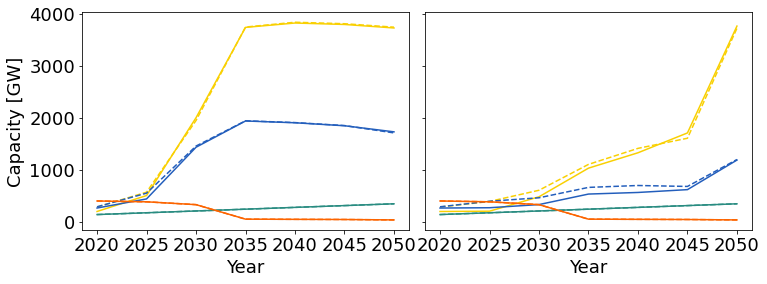

In [19]:
df = gen_df_for_cap_plot()

fig,axes = plt.subplots(1,2,figsize=(12,4),sharex=True,sharey='row')
axes = axes.flatten()

for i,scen in enumerate(['1.5','2']):
    df_i = df.loc[:,[f'{scen}_base',f'{scen}_no_gas']].T.unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.plot(color=[tech_colors[t] for t in list(df_i.columns.get_level_values(0))],
                style=['-','--']*10,
                ax=axes[i],
                legend=False)
    axes[i].set_ylabel('Capacity [GW]')
    axes[i].set_xlabel('Year')
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(7))
    #if i >=2:
    #    axes[i].set_ylim(0,500)
    #else :
    #    axes[i].set_ylim(500,3000)
#
fig.subplots_adjust(wspace=0.05)
#plt.tight_layout()


### Renewable capacities

In [20]:
df = nodal_capacities.loc[('generators',slice(None),slice(None))].groupby(level=2).sum()
renewable_techs = ['offwind',
        'offwind-ac',
        'offwind-dc',
        'onwind',
        'solar',
        'solar rooftop',
        'residential rural solar thermal',
        'residential urban decentral solar thermal',
        'services rural solar thermal',
        'services urban decentral solar thermal',
        'urban central solar thermal',
        'ror']
df = df.loc[renewable_techs]
df = df.groupby([rename_techs(t)for t in renewable_techs]).sum() * 1e-3
df.rename(index={'offshore wind':'offshore wind','offshore wind (AC)':'offshore wind','offshore wind (DC)':'offshore wind'},inplace=True)
df = df.groupby(level=0).sum()
df  = df.iloc[::-1]

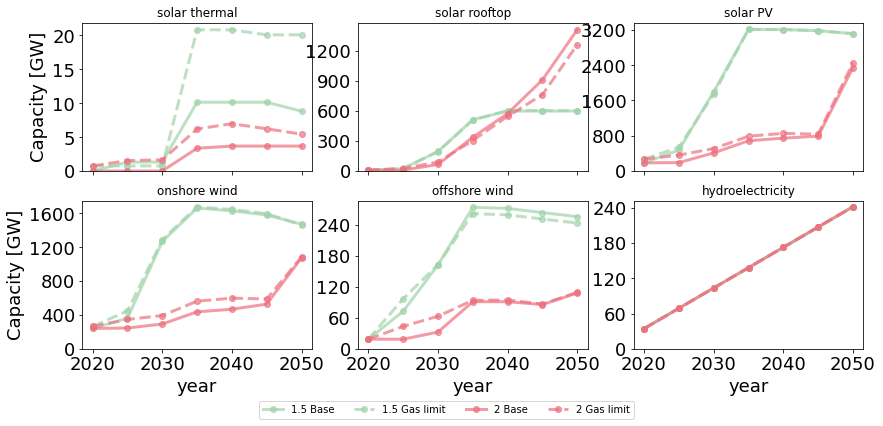

In [21]:
fig,axes = plt.subplots(2,3,figsize=(14,6),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(rename_techs(tech))
    start,end = axes[i].get_ylim()
    axes[i].set_ylim(0,end)
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Capacity [GW]')
axes[3].set_ylabel('Capacity [GW]')
axes[-1].legend(ncol=4,bbox_to_anchor=(0, -0.35),borderaxespad=0)

#plt.savefig('../figures/renewable_capacites.pdf',bbox_inches='tight')


### Generator capacities

In [22]:
fossil_generetor_techs = ['CCGT',
                            'OCGT',
                            'coal',
                            #'coal CC',
                            'lignite',
                            'oil',
                            'nuclear',
                            'urban central gas CHP',
                            #'urban central gas CHP CC',
                            'urban central solid biomass CHP',
                            'urban central solid biomass CHP CC'
                            ]
df = nodal_capacities.loc[('links',slice(None),fossil_generetor_techs)]

df= df.groupby(level=2).sum() * 1e-3
#df = df.groupby([rename_techs(t)for t in df.index]).sum() * 1e-3

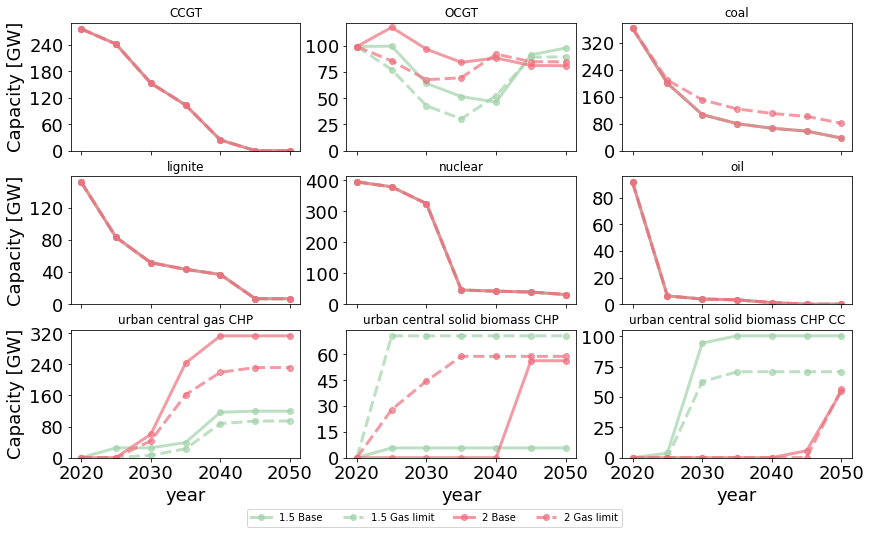

In [23]:
fig,axes = plt.subplots(3,3,figsize=(14,8),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],
                legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(tech)
    start,end = axes[i].get_ylim()
    axes[i].set_ylim(0,max((end,1)))
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Capacity [GW]')
axes[3].set_ylabel('Capacity [GW]')
axes[6].set_ylabel('Capacity [GW]')
axes[-1].legend(ncol=4,bbox_to_anchor=(0, -0.4),borderaxespad=0)

#plt.savefig('../figures/generator_capacites.pdf',bbox_inches='tight')

### Other tech capacities

In [24]:
other_techs = ['BEV charger',
                'DAC',
                'Fischer-Tropsch',
                'H2 Electrolysis',
                'H2 Fuel Cell',
                'SMR',
                'SMR CC',
                'Sabatier',
                #'V2G',
                'battery charger',
                #'battery discharger',
                #'helmeth',
                #'home battery charger',
                #'home battery discharger',
                #'biogas to gas',
                #'gas for industry',
                #'gas for industry CC',
                #'solid biomass for industry',
                #'solid biomass for industry CC'
                ]
df = nodal_capacities.loc[('links',slice(None),other_techs)]

df= df.groupby(level=2).sum() * 1e-3

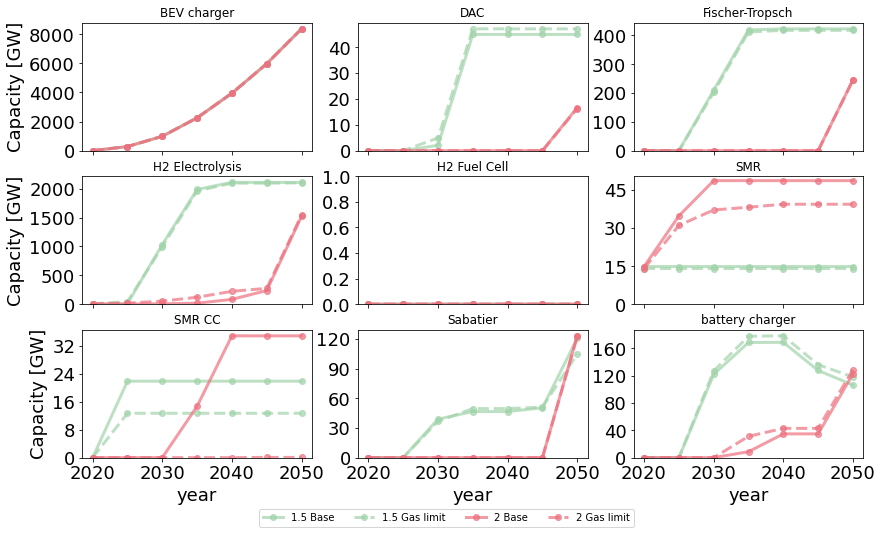

In [25]:
fig,axes = plt.subplots(3,3,figsize=(14,8),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],
                legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(tech)
    start,end = axes[i].get_ylim()
    axes[i].set_ylim(0,max((end,1)))
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Capacity [GW]')
axes[3].set_ylabel('Capacity [GW]')
axes[6].set_ylabel('Capacity [GW]')
#axes[9].set_ylabel('Capacity [GW]')
#axes[12].set_ylabel('Capacity [GW]')
axes[-1].legend(ncol=4,bbox_to_anchor=(0, -0.4),borderaxespad=0)

#plt.savefig('../figures/other_capacites.pdf',bbox_inches='tight')

### Storage capacities 

In [26]:
store_techs = ['battery',
                'H2',
                #'Li ion'
                #'residential rural water tanks',
                #'services rural water tanks', 
                'urban central water tanks',
                #'residential urban decentral water tanks',
                #'services urban decentral water tanks'
                ]
df = nodal_capacities.loc[('stores',slice(None),store_techs)]
df.rename({'urban central water tanks':'thermal water tanks'},inplace=True)

df= df.groupby(level=2).sum() * 1e-3

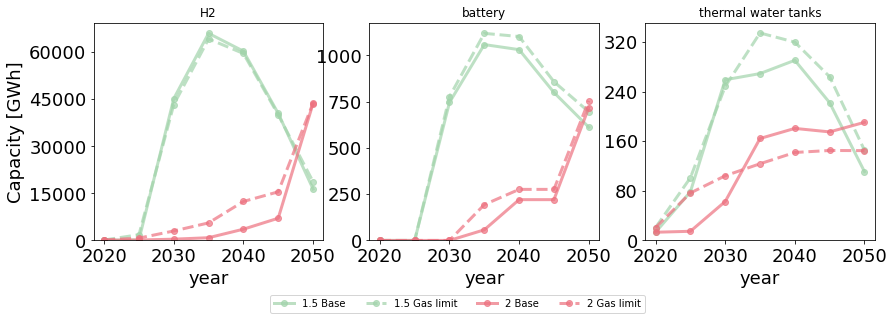

In [27]:
fig,axes = plt.subplots(1,3,figsize=(14,4),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],
                legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(tech)
    start,end = axes[i].get_ylim()
    axes[i].set_ylim(0,max((end,1)))
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Capacity [GWh]')
#axes[3].set_ylabel('Capacity [GW]')
#axes[6].set_ylabel('Capacity [GW]')
#axes[9].set_ylabel('Capacity [GW]')
#axes[12].set_ylabel('Capacity [GW]')
axes[-1].legend(ncol=4,bbox_to_anchor=(0, -0.25),borderaxespad=0)

#plt.savefig('../figures/storage_capacites.pdf',bbox_inches='tight')

In [28]:
gas_techs = ['H2 Electrolysis1',
            'biogas to gas1',
            'Sabatier1',
            'SMR1',
            'Fischer-Tropsch1',
            'SMR CC1',
            #'helmeth1',
            ]


df = supply_energy.loc[(slice(None),'links',gas_techs)]
df.index = df.index.get_level_values(2)
df.index = [i[:-1] for i in df.index]
df = df *1e-6

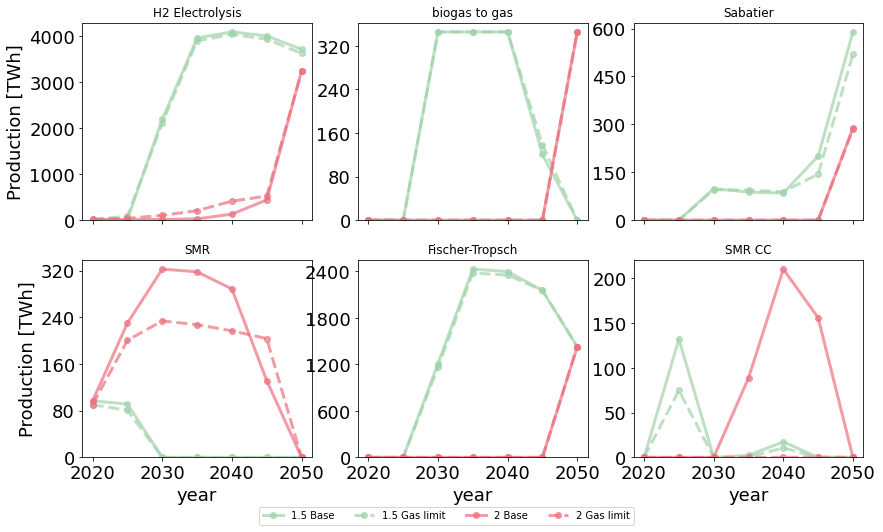

In [29]:
fig,axes = plt.subplots(2,3,figsize=(14,8),sharex=True)
axes = axes.flatten()

for i,tech in enumerate(df.index):
    df_i = df.loc[tech].unstack(level=0)
    df_i.index = df_i.index.astype(int)
    df_i.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)

    df_i.plot(ax=axes[i],
                legend=False,
                style=['-','--','-','--'],
                color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
                marker='o',
                alpha=0.7,
                linewidth=3,
                #color=['tab:blue','tab:blue','tab:orange','tab:orange']
                )
    axes[i].set_title(tech)
    start,end = axes[i].get_ylim()
    axes[i].set_ylim(0,max((end,1)))
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axes[i].set_xlabel('year')
axes[0].set_ylabel('Production [TWh]')
axes[3].set_ylabel('Production [TWh]')
axes[-1].legend(ncol=4,bbox_to_anchor=(0, -0.25),borderaxespad=0)

#plt.savefig('../figures/syngas_production.pdf',bbox_inches='tight')

## Primary energy plot

In [30]:
def make_primary_energy_df():
    co2_carriers = ["co2", "co2 stored", "process emissions"]
    v = [i for i in supply_energy.index.levels[0] if i not in co2_carriers]

    df = supply_energy.loc[(v,['generators','storage_units','stores'],slice(None))]
    df = df.loc[df.max(axis=1)>1e-2]
    df = df.groupby(level=2).sum() * 1e-6
    df = df.groupby(df.index.map(rename_techs)).sum()

    df_hp = supply_energy.loc[supply_energy.index.get_level_values(2).str.contains('heat pump')]
    df_hp.index = [i[:-1] if ((i != "co2") and (i[-1:] in ["0","1","2","3"])) else i for i in df_hp.index.get_level_values(2)]
    df_hp = df_hp.groupby(df_hp.index).sum() * 1e-6

    df = df.append(df_hp)
    tech_names = {'gas':'gas','air heat pump':'ambient heat', 'biogas':'biomass', 'coal':'coal', 'ground heat pump':'ambient heat',
                        'hydroelectricity':'hydro','hydro':'hydro', 'lignite':'lignite', 'offshore wind (AC)':'wind','offwind':'wind','onwind':'wind','offshore wind':'wind',
                        'offshore wind (DC)':'wind', 'oil':'oil', 'onshore wind':'wind', 'solar PV':'solar',
                        'solar rooftop':'solar', 'solar thermal':'solar', 'solid biomass':'biomass', 'uranium':'uranium','nuclear':'nuclear',
                        'residential rural ground heat pump':'ambient heat',
                        'residential urban decentral air heat pump':'ambient heat',
                        'services rural ground heat pump':'ambient heat',
                        'services urban decentral air heat pump':'ambient heat',
                        'urban central air heat pump':'ambient heat',
       }

    df = df.groupby([tech_names[t] for t in df.index]).sum()

    return df


In [31]:
def plot_energy(scen,ax,df=None,desired_order_list=None):
    if df is None:
        #df = make_primary_energy_df()
        df = make_historic_primary_energy()
    if desired_order_list is None:
        desired_order_list = ['gas','coal','lignite','oil' , 'hydro', 'wind'  , 'solar', 'biomass', 'uranium','ambient heat']

    #df = df.loc[:,df.columns.get_level_values(1)!='2020']

    title_scen = {'1.5_base':'Baseline','1.5_no_gas':'Gas limit','2_base':'Baseline','2_no_gas':'Gas limit'}
    df_dict = df[scen].T.to_dict(orient='list')
    df_dict = {k: df_dict[k] for k in desired_order_list}
    #ax.stackplot(df[scen].columns,df_dict.values(),labels=df_dict.keys(),colors=[tech_colors[t] for t in diff_dict.keys()],step='mid');

    df.loc[desired_order_list,scen].T.plot(kind='bar',stacked=True,width=0.9,color=[tech_colors[t] for t in desired_order_list],ax=ax,legend=False)    
    #ax.set_title(title_scen[scen],fontsize=fs,fontweight='bold')
    ax.set_ylabel(rf"$\bf{title_scen[scen]}$" + '\nPrimary energy [TWh]')

In [32]:
def make_historic_primary_energy():
    df_historic  = pd.read_excel('../data/EU, NO, UK primary energy source in 2019 (kTOE).xlsx',index_col=0).loc['EU + NO + UK']
    df_historic.rename({'heat pump':'ambient heat','geothermal':'other renewables and biofuels','non-renewable waste':'other renewables and biofuels','electricity':'other renewables and biofuels','uranium':'nuclear'},inplace=True)
    kToe_to_TWh = 1.163E-2
    df_historic = df_historic.groupby(level=0).sum()*kToe_to_TWh
    df_historic = df_historic.to_frame(name=('1.5_base','2020'))
    df_historic[('2_base','2020')] = df_historic[('1.5_base','2020')]
    df_historic[('2_no_gas','2020')] = df_historic[('1.5_base','2020')]
    df_historic[('1.5_no_gas','2020')] = df_historic[('1.5_base','2020')]

    df = make_primary_energy_df()
    df.rename({'offshore wind':'wind','onshore wind':'wind'},inplace=True)
    df = df.groupby(level=0).sum()
    df = df.loc[:,df.columns.get_level_values(1)!='2020']
    df = pd.concat((df_historic,df),axis=1)
    return df 


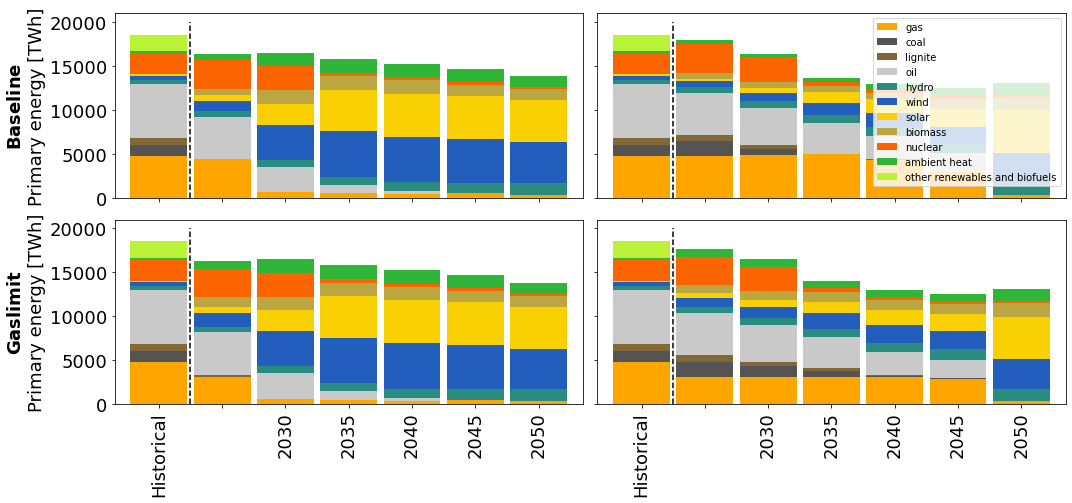

In [33]:
fig,ax = plt.subplots(2,2,figsize=(15,7),sharex=True,sharey=True)
desired_order_list=['gas','coal','lignite','oil', 'hydro',  'wind', 'solar', 'biomass', 'nuclear','ambient heat','other renewables and biofuels']
ax = ax.flatten()

scenarios = ['1.5_base','2_base','1.5_no_gas','2_no_gas']

for ax_i,scen in zip(ax,scenarios):
    plot_energy(scen, ax=ax_i,desired_order_list=desired_order_list)

ax[1].legend(loc='upper right') # Not needed when we merge with the other figure
#ax[0].set_ylabel('Primary energy [TWh]')
#ax[2].set_ylabel('Primary energy [TWh]')

labels = [item.get_text() for item in ax[3].get_xticklabels()]
labels[0] = 'Historical'
labels[1] = ''
ax[3].set_xticklabels(labels)

ax[0].vlines(0.5,0,20000,color='black',linestyle='--')
ax[1].vlines(0.5,0,20000,color='black',linestyle='--')
ax[2].vlines(0.5,0,20000,color='black',linestyle='--')
ax[3].vlines(0.5,0,20000,color='black',linestyle='--')

plt.tight_layout()
#plt.savefig('../figures/Primary_energy_grid.jpeg',dpi=1000,bbox_inches='tight')

## Gas figure

In [34]:
df = metrics.loc['co2_shadow'].unstack(level=0)
df.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)
df.columns.name = 'scenario'

In [35]:
df = gas_prices.pivot(index='year',columns='scenario') + 20.1
df.columns = df.columns.get_level_values(1)
df.rename(columns={'1.5':'1.5 Gas limit','2':'2 Gas limit'},inplace=True)
df['1.5 Base'] = 20.1
df['2 Base'] = 20.1
df


scenario,1.5 Gas limit,2 Gas limit,1.5 Base,2 Base
year,,,,
2020,48.151658,48.151464,20.1,20.1
2025,62.107971,82.682943,20.1,20.1
2030,20.100032,79.411611,20.1,20.1
2035,20.100000,62.459932,20.1,20.1
2040,20.100000,39.079209,20.1,20.1
2045,20.100000,20.100000,20.1,20.1
2050,20.100000,20.100000,20.1,20.1


In [36]:
df = metrics.loc['total costs']*1e-9
df = df.unstack(level=0).iloc[1:,:]
df.rename(columns={'1.5_base':'1.5 Baseline','1.5_no_gas':'1.5 Gas limit','2_no_gas':'2 Gas limit','2_base':'2 Baseline'},inplace=True)
df

opt,1.5 Basline,1.5 Gas limit,2 Baseline,2 Gas limit
planning_horizon,,,,
2025,NaN,765.805693,NaN,NaN
2030,969.242779,969.161303,NaN,NaN
2035,1052.268800,1052.916646,NaN,NaN
2040,1015.952421,1018.397861,NaN,NaN
2045,966.284202,966.036641,NaN,NaN
2050,909.550941,909.658550,NaN,NaN


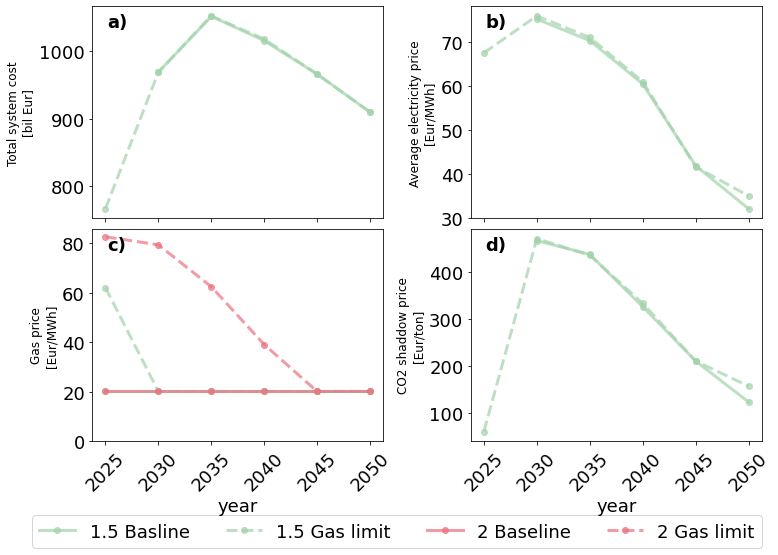

In [37]:
rc('text', usetex=False)
fig,ax = plt.subplots(2,2,figsize=(12,8),sharex=True)
ax = ax.flatten()

df = metrics.loc['co2_shadow'].unstack(level=0).iloc[1:,:]
df.rename(columns={'1.5_base':'1.5 Base','1.5_no_gas':'1.5 Gas limit','2_base':'2 Base','2_no_gas':'2 Gas limit'},inplace=True)
df.columns.name = 'scenario'
df.index = df.index.astype(int)
df.plot(ax=ax[3],
        style=['-','--','-','--'],
        color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
        linewidth=3,
        #drawstyle='steps-mid',
        alpha=0.7,
        marker='o',
        legend=False)
ax[3].set_ylabel('CO2 shaddow price\n[Eur/ton]',fontsize=12)
#ax[3].legend(loc='upper left')

# Total system cost
df = metrics.loc['total costs']*1e-9
df = df.unstack(level=0).iloc[1:,:]
df.rename(columns={'1.5_base':'1.5 Basline','1.5_no_gas':'1.5 Gas limit','2_no_gas':'2 Gas limit','2_base':'2 Baseline'},inplace=True)
df.index = df.index.astype(int)
df.plot(ax=ax[0],
        style=['-','--','-','--'],
        color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
        linewidth=3,
        #drawstyle='steps-mid',
        alpha=0.7,
        marker='o',
        legend=False)
ax[0].set_ylabel('Total system cost\n[bil Eur]',fontsize=12)

# Gas price
df = gas_prices.pivot(index='year',columns='scenario').iloc[1:,:] + 20.1
df.columns = df.columns.get_level_values(1)
df.rename(columns={'1.5':'1.5 Gas limit','2':'2 Gas limit'},inplace=True)
df['1.5 Base'] = 20.1
df['2 Base'] = 20.1
df.index = df.index.astype(int)
df.plot(ax=ax[2],
        style=['--','--'],
        color=['#A2D4AB','#ED717F'],
        linewidth=3,
        #drawstyle='steps-mid',
        alpha=0.7,
        marker='o',
        legend=False)
ax[2].set_ylabel('Gas price\n[Eur/MWh]',fontsize=12)
start, end = ax[2].get_ylim()
ax[2].set_ylim((0, end))

# El price
df = prices.loc['mean'].unstack(level=0).iloc[1:,:]
df.index = df.index.astype(int)
df.plot(ax=ax[1],style=['-','--','-','--'],color=['#A2D4AB','#A2D4AB','#ED717F','#ED717F'],
        linewidth=3,
        #drawstyle='steps-mid',
        alpha=0.7,
        marker='o',
        legend=False)
ax[1].set_ylabel('Average electricity price\n[Eur/MWh]',fontsize=12)


ax[2].xaxis.set_ticks(np.arange(2025, 2055, 5))
ax[2].tick_params(axis='x', labelrotation = 45)
ax[3].tick_params(axis='x', labelrotation = 45)
ax[2].set_xlabel('year')
ax[3].set_xlabel('year')

#ax[0].annotate('test',xy=(2030,860),xytext=(2030,750),xycoords='data', arrowprops=dict(facecolor='black', shrink=0.05))
#ax[3].xaxis.set_ticks(np.arange(-1, 4, 5))

plt.subplots_adjust(wspace=0.3,hspace=0.05)


for ax_i,t in zip(ax,['a)','b)','c)','d)',]):
    ax_i.text(0.05,0.9,t,transform = ax_i.transAxes,fontweight="bold",fontsize=fs)

ax[0].legend(ncol=4,bbox_to_anchor=(2.3, -1.4),borderaxespad=0,fontsize=fs)

#plt.savefig('../figures/prices.pdf',bbox_inches='tight')

## Ebbes Figure

In [38]:
tech_names = {'gas':'gas','air heat pump':'ambient heat', 'biogas':'biogas', 'coal':'coal', 'ground heat pump':'ambient heat',
                        'hydroelectricity':'hydro', 'lignite':'lignite', 'offshore wind (AC)':'offshore wind',
                        'offshore wind (DC)':'offshore wind', 'oil':'oil', 'onshore wind':'onshore wind', 'solar PV':'solar',
                        'solar rooftop':'solar', 'solar thermal':'solar', 'solid biomass':'biomass', 'uranium':'uranium'}

In [41]:
df

opt                  1.5_base                                         \
planning_horizon         2020         2025         2030         2035   
ambient heat       461.573127   644.991231  1513.271022  1591.111100   
biomass            702.380323   781.868241  1531.192715  1531.192715   
coal              1963.942319     2.375400     0.181808     1.198992   
gas               4043.789378  4393.130376   624.064152   513.184915   
hydro              488.237225   627.603492   763.434921   900.742321   
lignite           1327.828669    10.440769     0.000008     0.000219   
nuclear           3462.179404  3257.505482  2722.949360   390.884688   
oil               5191.129122  4819.955184  2934.029196   964.164215   
solar              236.621725   617.084566  2482.108478  4736.629285   
wind               621.419389  1192.679676  3917.544931  5200.579831   

opt                                                             2_base  \
planning_horizon         2040          2045          2050         2020   
ambient heat      1555.655577  1.493993e+03  1.187209e+03   461.572736   
biomass           1531.192715  1.306197e+03  1.185636e+03   702.380312   
coal                 4.166617  2.602463e+00  2.262113e+00  1963.942215   
gas                458.707373  4.967838e+02  3.589637e+02  4043.789529   
hydro             1041.607400  1.180499e+03  1.318838e+03   488.237202   
lignite              1.944000  3.001772e-01  2.881601e-01  1327.828638   
nuclear            362.859293  3.400521e+02  2.693560e+02  3462.179399   
oil                262.989183  6.656641e-08  1.629306e-08  5191.129157   
solar             4893.341215  4.855842e+03  4.785838e+03   236.621774   
wind              5169.912993  5.047786e+03  4.710214e+03   621.419514   

opt                                         ...   1.5_no_gas                \
planning_horizon         2025         2030  ...         2040          2045   
ambient heat       389.349547   352.539317  ...  1600.278080  1.497636e+03   
biomass            702.380179   702.380332  ...  1531.192715  1.324275e+03   
coal              1679.192932   746.124263  ...     4.048866  2.620264e+00   
gas               4776.353714  4862.591961  ...   396.593746  4.967431e+02   
hydro              628.270302   767.642580  ...  1044.804112  1.183924e+03   
lignite            730.296090   445.158813  ...     1.970047  3.052910e-01   
nuclear           3322.437717  2837.305789  ...   362.853838  3.376381e+02   
oil               4799.565123  4222.775474  ...   309.108003  1.213181e-07   
solar              246.950701   615.315097  ...  4901.938575  4.862408e+03   
wind               648.413791   881.846335  ...  5145.497199  5.025980e+03   

opt                                2_no_gas                            \
planning_horizon          2050         2020         2025         2030   
ambient heat      1.239332e+03   809.043050   880.856178   862.845131   
biomass           1.185636e+03   702.381124   907.552253  1020.356273   
coal              1.756745e+00  2457.710429  1709.952243  1194.558156   
gas               3.599963e+02  3099.999893  3100.000000  3100.000000   
hydro             1.323839e+03   488.237075   628.270107   768.198997   
lignite           2.035273e-01  1328.270652   727.384409   444.967278   
nuclear           2.703472e+02  3453.571323  3260.027249  2801.606648   
oil               3.498842e-08  5267.779130  4881.283773  4269.343492   
solar             4.803601e+03   351.738431   497.204966   752.093267   
wind              4.609491e+03   706.660827  1055.924646  1298.016226   

opt                                                                    
planning_horizon         2035         2040         2045          2050  
ambient heat       847.145995   786.657241   765.014788  1.335568e+03  
biomass           1128.222321  1135.731780  1146.934648  1.531193e+03  
coal               687.122732    87.346641    13.507019  1.274427e-05  
gas               3100.000000  3100.000000  2899.513944  3.634000e+02  


In [45]:
scen = '2'
df = make_primary_energy_df()

diff = df[f'{scen}_no_gas'] - df[f'{scen}_base']
diff.iloc[diff.values<0] = 0
diff_dict = diff.groupby(level=0).sum().T.to_dict(orient='list')

diff_dict['gas'] = list(supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum().values *1e-6)

desired_order_list = ['gas','coal','lignite','oil' , 'hydro',  'wind',  'solar', 'biomass', 'nuclear','ambient heat']
diff_dict = {k: diff_dict[k] for k in desired_order_list}

In [46]:
def plot_ebbes3(scen,ax):
    df = make_primary_energy_df()
    df = df.loc[:,df.columns.get_level_values(1)!='2020']


    diff = df[f'{scen}_no_gas'] - df[f'{scen}_base']
    diff.iloc[diff.values<0] = 0


    diff_dict = diff.groupby(level=0).sum().T.to_dict(orient='list')

    diff_dict['gas'] = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum().values[1:] *1e-6
    diff.loc['gas'] = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum().values[1:] *1e-6



    desired_order_list = ['gas','ambient heat' , 'wind', 'solar', 'biomass','oil','coal','lignite']
    diff_dict = {k: diff_dict[k] for k in desired_order_list}

    df_base = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_base'].sum()[1:] * 1e-6
    ax.plot([0,1,2,3,4,5],df_base.values,label=None,linewidth=5,color='black',)

    #df_base.plot(ax=ax,label='Gas use (unlimited)',linewidth=5,color='black',drawstyle='steps-mid')
    df_no_gas = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum()[1:] * 1e-6
    #ax.plot([0,1,2,3,4,5],df_no_gas.values,label='Gas use (unlimited)',linewidth=5,color='black',linestyle='--',)
    ax.plot([-0.5,1,2,3,4,5,6.5],[3100]*7,label=None,linewidth=3,color='black',linestyle='--',drawstyle='steps-mid')

    #df_no_gas.plot(ax=ax,label='Gas use (limited)',linewidth=5,color='black',linestyle='--',drawstyle='steps-mid')

    #diff.loc[desired_order_list].T.plot(kind='bar',stacked=True,width=0.9,color=[tech_colors[t] for t in desired_order_list],ax=ax,legend=False)    

    ax.stackplot(list(diff.columns),diff_dict.values(),labels=diff_dict.keys(),colors=[tech_colors[t] for t in diff_dict.keys()])
    #ax.fill_between(list(diff.columns),np.sum(list(diff_dict.values()),axis=0),supply_energy.loc[('gas','generators',slice(None)),f'{scen}_base'].sum() * 1e-6,hatch='//',color='white',edgecolor='black',label='Efficiency improvements')
    #ax.legend(loc='upper right')
    scen_title = {'1.5':'1.5C gas substitution','2':'2C gas substitution'}
    #ax.set_title(scen_title[scen],fontweight="bold",fontsize=fs)
    ax.set_xlabel('Year')
    ax.set_ylabel('Primary energy [TWh]')
    ax.set_xticks(np.arange(7))
    #ax.legend(loc='upper right')

In [47]:
def plot_ebbes2(scen,ax):
    df = make_primary_energy_df()
    #df.loc[:,df.columns.get_level_values(1)=='2020'] = 0


    diff = df[f'{scen}_no_gas'] - df[f'{scen}_base']
    diff.iloc[diff.values<0] = 0
    diff_dict = diff.groupby(level=0).sum().T.to_dict(orient='list')

    diff_dict['gas'] = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum().values *1e-6
    diff.loc['gas'] = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum().values *1e-6

    diff['2020'] = 0


    desired_order_list = ['gas','coal','lignite','oil' , 'hydro',  'wind', 'solar', 'biomass', 'nuclear','ambient heat']
    diff_dict = {k: diff_dict[k] for k in desired_order_list}

    df_base = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_base'].sum()[1:] * 1e-6
    ax.plot([0.5,1,2,3,4,5,6,6.5],df_base.values[[0,0,1,2,3,4,5,5]],label='Gas use (unlimited)',linewidth=3,color='black',drawstyle='steps-mid')

    #df_base.plot(ax=ax,label='Gas use (unlimited)',linewidth=5,color='black',drawstyle='steps-mid')
    df_no_gas = supply_energy.loc[('gas','generators',slice(None)),f'{scen}_no_gas'].sum()[1:] * 1e-6
    ax.plot([-0.5,1,2,3,4,5,6.5],[3100]*7,label='Gas use (unlimited)',linewidth=3,color='black',linestyle='--',drawstyle='steps-mid')
    #df_no_gas.plot(ax=ax,label='Gas use (limited)',linewidth=5,color='black',linestyle='--',drawstyle='steps-mid')

    diff.loc[desired_order_list].T.plot(kind='bar',stacked=True,width=0.9,color=[tech_colors[t] for t in desired_order_list],ax=ax,legend=False)    

    #ax.stackplot(list(diff.columns),diff_dict.values(),labels=diff_dict.keys(),colors=[tech_colors[t] for t in diff_dict.keys()],step='mid')
    #ax.fill_between(list(diff.columns),np.sum(list(diff_dict.values()),axis=0),supply_energy.loc[('gas','generators',slice(None)),f'{scen}_base'].sum() * 1e-6,hatch='//',color='white',edgecolor='black',label='Efficiency improvements')
    #ax.legend(loc='upper right')
    scen_title = {'1.5':'1.5C gas substitution','2':'2C gas substitution'}
    #ax.set_title(scen_title[scen],fontweight="bold",fontsize=fs)
    ax.set_xlabel('Year')
    ax.set_ylabel(r"$\bf{Difference}$" + '\nPrimary energy [TWh]')
    ax.set_xticks(np.arange(7))
    #ax.legend(loc='upper right')

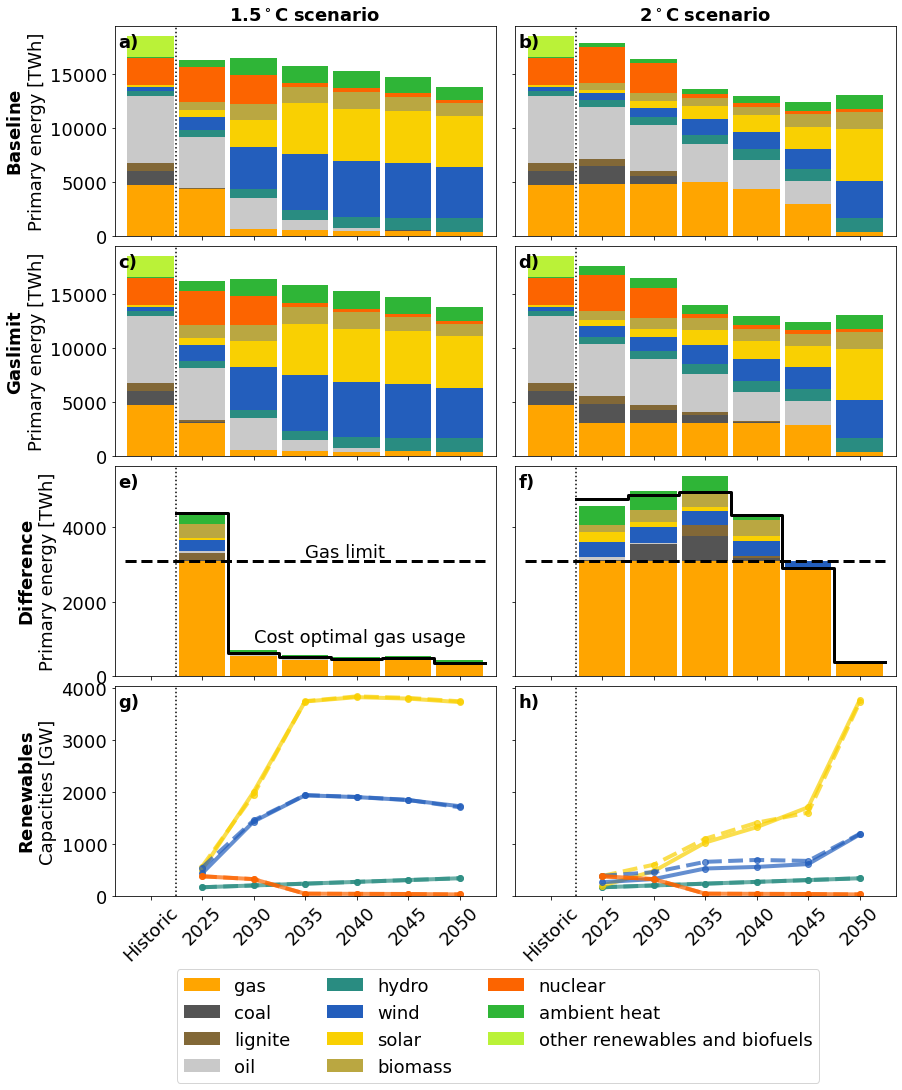

In [48]:
# Combined 
fig,ax = plt.subplots(4,2,figsize=(14,16),sharey='row',sharex=True)
ax = ax.flatten()

scenarios = ['1.5_base','2_base','1.5_no_gas','2_no_gas']
for ax_i,scen in zip(ax[:4],scenarios):
    plot_energy(scen, ax=ax_i,
                desired_order_list=['gas','coal','lignite','oil', 'hydro',  'wind', 'solar', 'biomass', 'nuclear','ambient heat','other renewables and biofuels']
)

scenarios = ['1.5','2']
for ax_i,scen in zip(ax[[4,5]],scenarios):
    plot_ebbes2(scen,ax_i)

df = gen_df_for_cap_plot()
#df = df.loc[:,df.columns.get_level_values(1)!='2020']
for i,scen in enumerate(['1.5','2']):
    df_i = df.loc[:,[f'{scen}_base',f'{scen}_no_gas']].T.unstack(level=0)
    df_i.loc['2020'] = np.nan

    #df_i.index = df_i.index.astype(int)
    
    df_i.plot(color=[tech_colors[t] for t in list(df_i.columns.get_level_values(0))],
                style=['-','--']*10,
                marker='o',
                alpha=0.7,
                ax=ax[i+6],
                linewidth=4,
                legend=False,
                label='test',
                #drawstyle='steps-mid'
                )
    ax[i+6].set_ylabel(r"$\bf{Renewables}$"+'\nCapacities [GW]')
    ax[i+6].set_xlabel('Year')
    #ax[i+6].set_title(f'{scen}C Renewable capacities',fontweight="bold",fontsize=fs)
    #ax[i+6].xaxis.set_major_locator(plt.MaxNLocator(7))

for ax_i in ax:
    start,end = ax_i.get_ylim()
    start = 0
    ax_i.set_ylim(start,end)
    ax_i.vlines(0.5,start,end,color='black',linestyle=':')

labels = [item.get_text() for item in ax[7].get_xticklabels()]
labels[0] = 'Historic'
ax[7].set_xticklabels(labels)
ax[7].set_xlabel('')
ax[6].set_xlabel('')
ax[6].tick_params(axis='x', labelrotation = 45)
ax[7].tick_params(axis='x', labelrotation = 45)

ax[0].set_title(r"$\bf{1.5^\circ C \; scenario}$",fontweight="bold",fontsize=fs)
ax[1].set_title(r"$\bf{2^\circ C \; scenario}$",fontweight="bold",fontsize=fs)

ax[4].annotate('Gas limit',xy=(3,3200),fontsize=fs)
ax[4].annotate('Cost optimal gas usage',xy=(2,900),fontsize=fs)

fig.subplots_adjust(wspace=0.05,hspace=0.05)
ax[3].legend(prop={'size':fs},ncol=3,bbox_to_anchor=(0.8, -2.45),borderaxespad=0)

#ax[6].legend(prop={'size':fs},ncol=3,bbox_to_anchor=(0.8, -2.45),borderaxespad=0)

for ax_i,t in zip(ax,['a)','b)','c)','d)','e)','f)','g)','h)']):
    ax_i.text(0.01,0.9,t,transform = ax_i.transAxes,fontweight="bold",fontsize=fs)

plt.savefig(f'../figures/primary_energy_grid2_pypsaeursec060.pdf',dpi=500,bbox_inches='tight')

## Graphical abstract plot

In [ ]:
# Graphical abstract
scen = '2'
fig,ax = plt.subplots(1,1,figsize=(10,6),sharey=True)
#for ax_i,scen in zip(ax,scenarios):
plot_ebbes3(scen,ax)

fig.subplots_adjust(wspace=0.05)
ax.legend(prop={'size':fs},ncol=3,bbox_to_anchor=(0.95, -0.12),borderaxespad=0)

ax.set_xlim([0,5])
ax.tick_params(axis='x', which='major', pad=15)
ax.set_xlabel('')

ax.text(5.2,150,
        'Restricted European\ngas supply',
        fontsize=fs,
        rotation=90,
        horizontalalignment='center',)
ax.text(4.2,3200,'Gas limit',fontsize=fs)
ax.annotate('Energy\nreplacing gas',
            xy=(2.8,3700),
            xytext=(5.2,3400),
            fontsize=fs,
            horizontalalignment='center',
            rotation=90,
            #arrowprops=dict(facecolor='black', shrink=0.05)
            )
#ax.annotate('Lower efficiency',
#            xy=(2,5000),
#            xytext=(3.2,5000),
#            fontsize=fs,
#            horizontalalignment='center',
#            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Cost optimal\nunrestricted\ngas use',
            xy=(3.3,3800),
            xytext=(4.2,4300),
            fontsize=fs,
            horizontalalignment='center',
            arrowprops=dict(facecolor='black', shrink=0.05))


#plt.savefig(f'../figures/GraphAbstract.pdf',dpi=500,bbox_inches='tight')